In [66]:

import pandas as pd

import pytorch_lightning as pl
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor

from sklearn.neural_network import MLPRegressor

from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

from sklearn.linear_model import LinearRegression

import seaborn as sns
import matplotlib.pyplot as plt
from fccd.data.modules import CDDDataModule

from fccd.data.datasets import TabularDataset
from fccd.models.LSTM import PostAggregationLSTM, RepeatedInputLSTM, RawHiddenStateLSTM, EncodedHiddenStateLSTM, \
    ChunkingEncodedHiddenStateLSTM, KindOfTemporalFusionTransformer
from fccd.models.baseline import HammingDistanceBaseline, KNNBaseline

import torch

from fccd.models.GBT import LightGBMModel

from pytorch_forecasting import GroupNormalizer

import numpy as np
from fccd.util import plot_prediction_vs_truth, find_lr, plot_prediction_vs_truth_sklearn, limit_psd

from fccd.util import collect_dataloader

from sklearn.metrics import mean_squared_error

from sklearn.tree import DecisionTreeRegressor
import statsmodels.api as sm

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Predicting height of Stress-Strain Curve

Many neural net based models fail to correctly anticipate the height of the stress-strain curve. We therefore investigate how tree-based models estimations are different from lstm predictions.

The excerpt below illustrates that the variance of LSTM predictions is a lot higher. LSTMs seem to predict the shape very vell but fail to capture the magnitude of the curve. We investigate what's the reason for that.

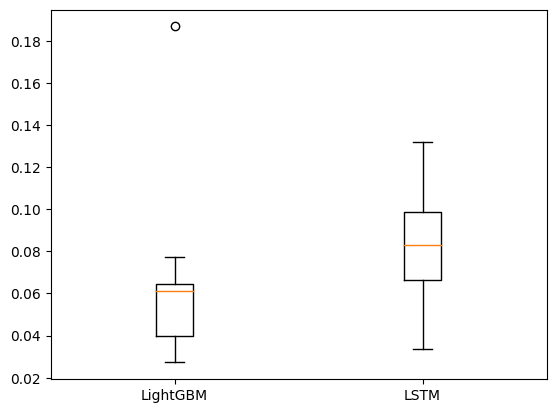

In [19]:
# Data excerpt from past experiments
gbt = [0.06881821153608615,0.07029270552732624,0.09537631894721561,0.033495462711951,0.0982647672417454,0.06579750534445589,0.09867729303807031,0.048471533835822644,0.10217566226107663,0.13169150594845175]
enc= [0.027221402778413166,0.07714186411027153,0.06422770702241051,0.05908254355216353,0.18675595914315613,0.035079025183194584,0.06294874310646639,0.02908582165664398,0.06476291348840323,0.05345450002972341]

plt.boxplot([enc, gbt], labels=["LightGBM", "LSTM"])
plt.show()

## Data preparation

Load data, limit psd and prepare data module

In [37]:
data_125 = pd.read_csv("../data/processed/cu_125.csv", index_col=0)
data_1000 = pd.read_csv("../data/processed/cu_1000.csv", index_col=0)

data = pd.concat([data_125, data_1000])
data = data.reset_index(drop=True)

data["stress"] = data["stress"] * 1000
data["psd"] = data["psd"] * 1000

split_data = limit_psd(data)

In [39]:
stress_dm = CDDDataModule(
    split_data,
    target="stress",
    psd="psd",
    group="id",
    drop_cols=["strain", "time_ns", "dislocation"],
    time="t",
    batch_size=64,
    categoricals=["material", "euler_angles", "mesh"],
    num_dataloader_workers=4,
    transform=MinMaxScaler,
    split_dataset=True,
)
stress_dm.setup()

In [90]:
train_data = stress_dm.train_dataset()
val_data = stress_dm.val_dataset()
test_data = stress_dm.test_dataset()

maxy_train_data = TabularDataset.max_y_from_cdd_dataset(train_data)
maxy_val_data = TabularDataset.max_y_from_cdd_dataset(val_data)
maxy_test_data = TabularDataset.max_y_from_cdd_dataset(test_data)

x_train, y_train = maxy_train_data.dataset
x_val, y_val = maxy_val_data.dataset
x_test, y_test = maxy_test_data.dataset

stackedx_train = torch.cat([x_train, x_val], dim=0)
stackedy_train = torch.cat([y_train, y_val], dim=0)

## Feature importance for curve magnitude

To assess feature importancem, we train a decision tree and look at the feature importance rankings.

In [87]:
dt = DecisionTreeRegressor()
dt.fit(stackedx_train, stackedy_train)

DecisionTreeRegressor()

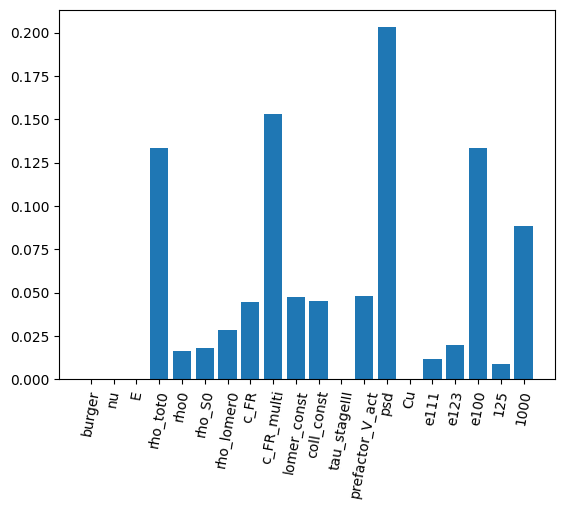

In [89]:
ticks = range(len(dt.feature_importances_))
plt.bar(x=ticks, height=dt.feature_importances_)
plt.xticks(ticks, maxy_train_data.x_names[0], rotation=80)
plt.show()

We observe, that rho_tot0, c_FR_multi and e100 stand out. Next, we evaluate how prediction performance changes, if we omit the other variables.

In [92]:
trimmed_values = ["rho_tot0", "c_FR_multi", "e100"]
df = pd.DataFrame(stackedx_train, columns=maxy_train_data.x_names[0])
trimmed_df = df[trimmed_values]

x = sm.add_constant(trimmed_df)
lr = sm.OLS(stackedy_train, x).fit()
print(lr.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.203
Model:                            OLS   Adj. R-squared:                  0.202
Method:                 Least Squares   F-statistic:                     139.7
Date:                Sun, 30 Oct 2022   Prob (F-statistic):           1.27e-80
Time:                        17:57:50   Log-Likelihood:                 1130.7
No. Observations:                1647   AIC:                            -2253.
Df Residuals:                    1643   BIC:                            -2232.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2894      0.005     54.707      0.0

In [84]:
x = sm.add_constant(df)
lr = sm.OLS(stackedy_train, x).fit()
print(lr.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.264
Model:                            OLS   Adj. R-squared:                  0.259
Method:                 Least Squares   F-statistic:                     53.34
Date:                Sun, 30 Oct 2022   Prob (F-statistic):          8.32e-101
Time:                        17:51:31   Log-Likelihood:                 1196.1
No. Observations:                1647   AIC:                            -2368.
Df Residuals:                    1635   BIC:                            -2303.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            3.045e+11   6.19e+11     

The results indicate, that the three variables rho_tot0, c_FR_multi and e100 have significant influence on the maximum value of a curve.

The $R^2$ value decreases by ~0.06 when omitting the other parameters. 